# HMM build and analysis

Here we will construct and analyze HMM models using MSA as the input data. We will utilize several databases as sources to enhance our analysis and gain valuable insights from the generated HMM profiles.

## Load the data

We are working only with the disordered regions, thus we should keep only the related information.


In [1]:
# Importing the libraries and functions
from functions import *

In [2]:
# Keep only disordered regions in the initial dataframe filtering using curated_disordered dataframe
disordered = pd.read_csv("disordered_df.csv")
print(f"The number of rows containing disordered regions: {len(disordered)}")
disordered.head(5)

The number of rows containing disordered regions: 2887


,query_id,subject_id,query_len,hsp_len,query_seq,match_seq,subject_seq,query_start,query_end,subject_start,subject_end,identity,positive,gaps,eval,bit_score,count
0,Q9H832,A0A6J2FM24,354,356,MAESPTEEAATA--GAGAAGPGASSVAGVVGVSGSGGGFGPPFLPD...,MAESPTEEAATA GAGAAGPGAS V GVVGVSGSG FGPPFLPD...,MAESPTEEAATATAGAGAAGPGASGVTGVVGVSGSG--FGPPFLPD...,1,354,1,354,350,350,4,0.0,1851.0,200
1,Q9H832,A0A3Q7W6Y2,354,356,MAESPTEEAATA--GAGAAGPGASSVAGVVGVSGSGGGFGPPFLPD...,MAESPTEEAATA GAGA GPGAS VAGVVGVSGSG FGPPFLPD...,MAESPTEEAATATAGAGATGPGASGVAGVVGVSGSG--FGPPFLPD...,1,354,1,354,350,350,4,0.0,1851.0,200
2,Q9H832,A0A2U3VK69,354,356,MAESPTEEAATA--GAGAAGPGASSVAGVVGVSGSGGGFGPPFLPD...,MAESPTEEAATA GAGAAGPGAS V GVVGVSGSG FGPPFLPD...,MAESPTEEAATATAGAGAAGPGASGVTGVVGVSGSG--FGPPFLPD...,1,354,1,354,350,350,4,0.0,1851.0,200
3,Q9H832,A0A2Y9JVH5,354,358,MAESPTEEAATA----GAGAAGPGASSVAGVVGVSGSGGGFGPPFL...,MAESPTEEAATA GAGAAGPGAS VAGVVGVSGSG FGPPFL...,MAESPTEEAATATATAGAGAAGPGASGVAGVVGVSGSG--FGPPFL...,1,354,1,356,351,351,6,0.0,1854.0,200
4,Q9H832,A0A8C7ALE4,354,358,MAESPTEEAATA----GAGAAGPGASSVAGVVGVSGSGGGFGPPFL...,MAESPTEEAATA GAGAAGPGAS VAGVVGVSGSG FGPPFL...,MAESPTEEAATATATAGAGAAGPGASGVAGVVGVSGSG--FGPPFL...,1,354,1,356,351,351,6,0.0,1854.0,200


In [3]:
# Filter the curated_disprot dataframe on Uniprot query ID
%store -r id_dis
id = id_dis
curated_disprot = pd.read_csv("curated_disprot.csv")
curated_query = curated_disprot[curated_disprot['acc'] == id]

print(f"The number of disordered regions found in the {id} protein: {len(curated_query)}")
curated_query.head()

The number of disordered regions found in the Q86FP8 protein: 1


,acc,evidence,feature,source,start,end,length
894,Q86FP8,curated,disorder,disprot,20,80,61


In [4]:
# # Select the region and set the paths to HMM and MSA files
i = 1 # change the number if there are several regions in a protein
# hmm_file = f'{directory}/results/hmms/hmmbuild/{id_dis}_{i}.hmm'
# align_file = f'{directory}/results/alignments/output_files/disordered/{id_dis}_{i}.fasta'

## 1. Build HMM
We generate HMM model with `hmmbuild` using MSA as an input.

## 2. HMMsearch

After building the model, our objective is to assess if overlaps with the profiles in Reference Proteome 15% exist and to enrich the model by utilizing this database. We generate dataframes containing the most significant sequences, with a default E-value threshold of 0.01.

### Analysis of a single query ID: overlap between HMMsearch results and protein2ipr

In [16]:
# Make a dataframe with the statistics
stats_rp_15 = pd.read_csv(f"{directory}/results/hmms/hmmsearch/stats/stats_rp_15_{id}_{i}.csv")
stats_rp_15

FileNotFoundError: [Errno 2] No such file or directory: 'pfam_overlap.csv'

In [6]:
# Filter only entries with Pfam ID and intercepting regions with the curated_disprot instances
pfam_overlap = pd.read_csv("pfam_overlap.csv")
pfam_overlap

,uniprot_id,ipr_id,description,pfam_id,start_pos,end_pos,length
0,Q5VZK9,IPR031943,"CARMIL, C-terminal domain",PF16000,786,1079,294


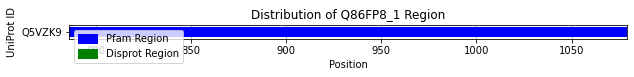

In [7]:
def plot_overlapping_regions(pfam_overlap, curated_query, id, i):
    unique_uniprot_ids = pfam_overlap['uniprot_id'].unique()

    if len(unique_uniprot_ids) == 0:
        print("No overlapping regions to plot.")
        return

    # Plot overlapping regions
    fig, ax = plt.subplots(figsize=(10, 0.25 * len(unique_uniprot_ids)))

    # Plot the regions
    ax.hlines(pfam_overlap['uniprot_id'], pfam_overlap['start_pos'], pfam_overlap['end_pos'], linewidth=10, color='blue', label='Pfam Region')
    ax.hlines(pfam_overlap['uniprot_id'], curated_query['start'], curated_query['end'], linewidth=10, color='green', label='Disprot Region')

    ax.set_yticks(pfam_overlap['uniprot_id'])
    ax.set_yticklabels(pfam_overlap['uniprot_id'])
    ax.set_xlim(pfam_overlap['start_pos'].astype(int).min(), pfam_overlap['end_pos'].astype(int).max())

    ax.axvspan(curated_query['start'].iloc[0], curated_query['end'].iloc[0], facecolor='yellow', alpha=0.5)

    plt.title(f'Distribution of {id}_{i} Region')
    plt.xlabel('Position')
    plt.ylabel('UniProt ID')
    plt.legend(loc='upper left')
    plt.grid(True)
    plt.show()

plot_overlapping_regions(pfam_overlap, curated_query, id, i)

### Analysis of overall HMMsearch results and protein2ipr overlap


In [9]:
def extract_table_from_output(hmm_result_file):
    with open(hmm_result_file, 'r') as f:
        lines = f.readlines()

        # Extract a query ID
        query_id = None
        extract_info = False
        result_data = []

        for line in lines:
            if line.startswith(">>"):
                query_id = line.strip()[2:].split(" ")[1]
                extract_info = True  # Set the flag to True when query ID is found
            elif extract_info:
                line_data = line.split()
                if line_data[0].isdigit():
                    try:
                        hmm_from = int(line_data[6])
                        hmm_to = int(line_data[7])
                        env_from = int(line_data[12])
                        env_to = int(line_data[13])
                        result_data.append([query_id, hmm_from, hmm_to, env_from, env_to])
                    except ValueError:
                        pass
                    extract_info = False

        # Create and return the DataFrame
        result_df = pd.DataFrame(result_data, columns=['id', 'hmm from', 'hmm to', 'env from', 'env to'])
        return result_df

In [10]:
# Create a dataframe with extracted regions from HMM
hmm_result_file = f"{directory}/results/hmms/hmmsearch/hmmsearch_rp_15_{id}_{i}.txt"
result_table = extract_table_from_output(hmm_result_file)
result_table.to_csv(f"{directory}/results/hmms/hmmsearch/stats/stats_rp_15_regions_{id}_{i}.csv")
result_table

,id,hmm from,hmm to,env from,env to
0,A9TSC0,11,61,305,360
1,A0A384L621,6,59,280,339
2,Q9LIP9,6,59,280,339
3,A0A834T8N5,10,59,333,391
4,A0A6A6KBW9,7,59,267,325
...,...,...,...,...,...
767,A0A099L288,11,59,225,277
768,A0A151AML1,28,59,223,276
769,A0A843TFX8,27,56,14,52
770,A0A4Z0FEB4,25,60,225,277


In [34]:
# !scp {directory}/results/hmms/hmmsearch/stats/stats_rp_15_regions_{id}_{i}.csv {name}@{server}:~/stats_rp_15_regions_{id}_{i}.csv

In [35]:
# !ssh {name}@{server} "/home/alina/protein2ipr_iterator.py stats_rp_15_regions_{id}_{i}.csv /db/interpro/protein2ipr.dat.gz protein2ipr_rp_15_regions_{id}_{i}.txt"

## 3. HHblits

HHblits is used for profile-profile sequence alignment. It compares a profile against a target sequence database to find homologous sequences.

In [11]:
# # Copy fasta file to remote folder
# !scp {align_file} {name}@{server}:~/{id}_{i}.fasta

In [12]:
# # HHblits against Pfam
# !ssh {name}@{server} "/software/packages/hhsuite/hhsuite-3.0-beta.3-Linux/bin/hhblits -i {id}_{i}.fasta -o hhblits_pfam_{id}_{i}.txt -d /db/hhblits/pfamA_35.0/pfam"

In [39]:
# # Copy results to the local folder
# !scp {name}@{server}:~/hhblits_pfam_{id}_{i}.txt {local_path}/results/hmms/hhblits/

- `Hit`: contains information about Pfam identifier (starts with PF...), the abbreviated and full name of the domain.
- `Prob`: the probability of the match between the query sequence and the template sequence.
- `E-value`: the expected number of false positive matches that could occur by chance.
- `P-value`: the probability of obtaining a match with a score as good as or better than the observed score purely by chance.
Similar as `E-value`, the lower `P-value` indicate more significant matches.
- `Score`: the quality of the alignment between the query and template sequences.
- `SS (Secondary Structure)`: the predicted secondary structure of the aligned residues in the template sequence.
- `Cols`: the number of aligned columns or residues in the alignment between the query and template sequences.
- `Query HMM`: indicates position matches within HMM profile (input).
- `Template HMM`: indicates position matches within HMM profile (database).
Usually the length of template HMM is bigger than the length of query HMM.

In [40]:
with open(f'{directory}/results/hmms/hhblits/hhblits_pfam_{id}_{i}.txt', 'r') as file:
    lines = file.readlines()

# Extract the column names
column_names = lines[8].split()[:-4] + ['Query HMM', 'Template HMM']

# Extract the data rows
data_rows = [line.split() for line in lines[9:19]]
data_rows = [[row[0]] + [' '.join(row[1:4])] + row[7:14] + [' '.join(row[14:16])]
             for row in data_rows]

hhblits_stats = pd.DataFrame(data_rows, columns=column_names)
hhblits_stats[["Hit", "Name"]] = hhblits_stats["Hit"].str.split(" ; ", expand=True)
hit_split_df = hhblits_stats["Hit"].str.split(".", expand=True)
hhblits_stats["Hit"] = hit_split_df[0]

hhblits_stats = hhblits_stats.drop("No", axis=1).reset_index(drop=True)
hhblits_stats.to_csv(f'{directory}/results/hmms/hhblits/hhblits_pfam_{id}_{i}.csv', index=False)
hhblits_stats

,Hit,Prob,E-value,P-value,Score,SS,Cols,Query HMM,Template HMM,Name
0,PF18633,3.8,0.00067,19.6,0.0,7,39-45,1-7,(28),zf-CCCH_8
1,PF08958,12,0.0029,17.9,0.0,10,78-87,4-13,(77),DUF1871
2,PF14443,16,0.0034,20.9,0.0,14,37-50,85-98,(119),DBC1
3,PF10051,43,0.0084,20.3,0.0,11,78-88,32-42,(163),DUF2286
4,PF13955,48,0.0093,13.6,0.0,7,77-83,14-20,(21),Fst_toxin
5,PF19937,49,0.0097,17.9,0.0,12,76-87,19-30,(89),GldC-like
6,PF07896,59,0.012,15.2,0.0,13,82-94,32-44,(50),DUF1674
7,PF05829,96,0.017,15.1,0.0,16,34-49,11-26,(42),Adeno_PX
8,PF18513,1.3E+02,0.023,16.5,0.0,16,32-47,50-65,(88),Pro_sub2
9,PF16643,1.1E+02,0.024,17.4,0.0,12,84-95,84-95,(168),cNMPbd_u2


In [329]:
# # Copy again the new files to the remote computer
# !scp {local_path}/results/hmms/hhblits/hhblits_pfam_{id}_{i}.csv {name}@{server}:~/hhblits_pfam_{id}_{i}.csv

In [70]:
# !ssh {name}@{server} "/home/alina/hhblits_iterator.py hhblits_pfam_{id}_{i}.csv /db/interpro/protein2ipr.dat.gz pfam_uniprot_{id}_{i}.txt"